In [1]:
!nvidia-smi

Thu May 13 23:35:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1E:00.0 Off |                    0 |
| N/A   31C    P0    42W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
sys.path.append('../../')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import pandas as pd
import scipy
from tqdm import tqdm
import json
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
from tqdm import tqdm
from typing import Tuple, List
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob 
from dateutil import parser
import dateutil
import transformers
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
import warnings
warnings.filterwarnings("ignore")
from scripts.get_train_test import normalize_target
from scripts.metrics import get_metrics, plot_two_distributions
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize

In [5]:
def get_metrics(y_test, predicted_y):
    mse = round(mean_squared_error(y_test, predicted_y), 4)
    mae = round(mean_absolute_error(y_test, predicted_y),4)
    r = round(r2_score(y_test, predicted_y), 4)
    pearsonr_corr, pearsonr_corr_p = stats.pearsonr(y_test, predicted_y)
    spearman_corr, spearman_p = stats.spearmanr(y_test, predicted_y)
    print("Report:")
    print(f"mean_squared_error: {mse}\nmean_absolute_error: {mae}\nr2_score {r}")
    print(f"pearsonr_corr: {round(pearsonr_corr, 4)}, pearsonr_p: {round(pearsonr_corr_p, 4)}")
    print(f"spearman_corr: {round(spearman_corr, 4)}, spearman_p: {round(spearman_p, 4)}")
    print()
    return mse, mae, r, pearsonr_corr

In [6]:
def get_base_data():
    base_path = "../../data/Data DigitalFreud/final_data/"
    base_info_path = '1/item1.csv'

    base_info_file = os.path.join(base_path, base_info_path)
    base_info = pd.read_csv(base_info_file)
    base_info = base_info[(base_info.who_score.notna()) & (base_info.diener_score.notna())]
    return base_info

base_info = get_base_data()


In [7]:
base_info

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [8]:
base_info_no_test = base_info[base_info.duplicated("vk_id_encrypted") == False]

In [9]:
base_info_no_test

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [10]:
files = glob("../../data/proc_messages-date-user2/texts/*")
files[:10]

['../../data/proc_messages-date-user2/texts/311226232.json.gz',
 '../../data/proc_messages-date-user2/texts/55106467.json.gz',
 '../../data/proc_messages-date-user2/texts/282720738.json.gz',
 '../../data/proc_messages-date-user2/texts/122949173.json.gz',
 '../../data/proc_messages-date-user2/texts/220419749.json.gz',
 '../../data/proc_messages-date-user2/texts/90175295.json.gz',
 '../../data/proc_messages-date-user2/texts/137479231.json.gz',
 '../../data/proc_messages-date-user2/texts/609145811.json.gz',
 '../../data/proc_messages-date-user2/texts/695942899.json.gz',
 '../../data/proc_messages-date-user2/texts/52851195.json.gz']

In [11]:
# prepare data: for each user get messages in interval [freud_install_time - 3 months; freud_install_time]

In [12]:
from glob import glob
path_to_messages = "../../data/proc_messages-date-user2/texts/"
all_users_with_messages = [int(os.path.basename(f).split(".")[0]) for f in glob(os.path.join(path_to_messages, "*"))]
all_users_with_messages[:10]

[311226232,
 55106467,
 282720738,
 122949173,
 220419749,
 90175295,
 137479231,
 609145811,
 695942899,
 52851195]

In [13]:
def found_data(x):
    return True if x in all_users_with_messages else False

base_info_no_test["found_messages"] = base_info_no_test.vk_id_encrypted.apply(found_data)

In [14]:
base_info_no_test[base_info_no_test["found_messages"] == True]

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,...,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,found_messages
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,...,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22,True
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,...,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11,True
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,...,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38,True
7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,23.0,4.0,4.0,...,1.0,1.0,24.0,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,True
10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,10.0,6.0,6.0,...,2.0,6.0,9.0,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,13.0,4.0,4.0,...,3.0,6.0,16.0,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,True
2033,0574c52f-84d4-21b1-5447-03f1559a655f,354174379,2.0,1.0,2.0,3.0,0.0,22.0,2.0,5.0,...,2.0,5.0,19.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-30 09:03:00,True
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,...,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,True
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,...,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,True


In [15]:
base_info_no_test_with_messages = base_info_no_test[base_info_no_test["found_messages"] == True]

In [16]:
needed_columns = ["vk_id_encrypted", "freud_install_time", "who_score", "diener_score"]

In [17]:
for row in base_info_no_test_with_messages[needed_columns][:5].iterrows():
    print(row[1]["freud_install_time"])

2018-06-26 13:01:22
2018-07-08 08:33:11
2018-06-28 18:57:38
2018-07-17 11:38:02
2018-08-28 13:33:33


In [18]:
prepared_data  = base_info_no_test_with_messages.reset_index()[needed_columns]
prepared_data

,vk_id_encrypted,freud_install_time,who_score,diener_score
0,677093196,2018-06-26 13:01:22,16.0,19.0
1,188075273,2018-07-08 08:33:11,14.0,25.0
2,435358060,2018-06-28 18:57:38,12.0,22.0
3,518613556,2018-07-17 11:38:02,23.0,24.0
4,200269216,2018-08-28 13:33:33,10.0,9.0
...,...,...,...,...
851,540669219,2018-03-29 10:04:57,13.0,16.0
852,354174379,2018-06-30 09:03:00,22.0,19.0
853,954555625,2018-08-27 01:15:08,16.0,15.0
854,849073825,2018-03-27 08:28:00,15.0,21.0


In [19]:
by_user_dialog_number = []
by_user_message_number = []
user_texts = []
by_user_by_speakers_messages = []
choised_indicies = []
vk_ids_choised = []

for row in tqdm(prepared_data.iterrows()):
    right_boundary = parser.parse(row[1]["freud_install_time"])
    left_boundary = right_boundary - dateutil.relativedelta.relativedelta(**{"months": 6})
    texts_filtered_by_dates = []
    messages_file_path = f"../../data/proc_messages-date-user2/texts/{row[1]['vk_id_encrypted']}.json.gz"
    with gzip.open(messages_file_path, 'r') as f_in:
        original_texts = json.load(f_in)
        messages_by_spakers = []
        for speaker_id, messages in original_texts.items():
            spaker_available_messages = []
            for message, time in messages:
                time = parser.parse(time)
                if left_boundary <= time <= right_boundary:
                    spaker_available_messages.append(message)
            if spaker_available_messages:
                messages_by_spakers.append(spaker_available_messages)
                    
        if len(messages_by_spakers) > 0:
            choised_indicies.append(row[0])
            vk_ids_choised.append(row[1]['vk_id_encrypted'])
            by_user_dialog_number.append(len(messages_by_spakers))
            by_user_message_number.append(sum([len(x) for x in messages_by_spakers]))
            by_user_by_speakers_messages.append(messages_by_spakers)
            user_texts.append([m for ms in messages_by_spakers for m in ms])

856it [1:17:05,  5.40s/it]


In [20]:
message_stats = pd.DataFrame(
    {"by_user_dialog_number": by_user_dialog_number, 
     "by_user_message_number": by_user_message_number,
     "by_user_by_speakers_messages": by_user_by_speakers_messages,
    "user_texts": user_texts,
     "vk_ids_choised": vk_ids_choised
    })

In [21]:
message_stats

,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised
0,39,8623,[[за 1.12\nхол. в- 642\nэлектр.- 21344\nгаз - ...,[за 1.12\nхол. в- 642\nэлектр.- 21344\nгаз - 5...,435358060
1,17,4817,"[[это как?, Ясно, С праздником), :), как жизнь...","[это как?, Ясно, С праздником), :), как жизнь?...",518613556
2,15,1187,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216
3,9,21827,"[[Ну что ж.. Хатико ждал и мы подождем, Лунтик...","[Ну что ж.. Хатико ждал и мы подождем, Лунтик ...",305836538
4,1,5,"[[Привет, Надо разлочить плпншет от мегафона и...","[Привет, Надо разлочить плпншет от мегафона ир...",407369402
...,...,...,...,...,...
759,46,1033,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219
760,29,13012,"[[😂😂, оор, ты бы стал пересматривать наруто с ...","[😂😂, оор, ты бы стал пересматривать наруто с с...",354174379
761,31,3932,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625
762,129,39918,"[[смотря что нужно, какие?, обратись лучше к н...","[смотря что нужно, какие?, обратись лучше к на...",849073825


In [22]:
messages_with_scores = pd.concat([prepared_data.iloc[choised_indicies].reset_index(), message_stats], axis=1)

In [23]:
# with open("./messages_with_scores.json", "w") as f:
#     json.dump(messages_with_scores.to_dict(), f, ensure_ascii=False, indent=4)

In [24]:
# !head message_stats.json

In [25]:
message_stats = pd.DataFrame(messages_with_scores)
message_stats

,index,vk_id_encrypted,freud_install_time,who_score,diener_score,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised
0,2,435358060,2018-06-28 18:57:38,12.0,22.0,39,8623,[[за 1.12\nхол. в- 642\nэлектр.- 21344\nгаз - ...,[за 1.12\nхол. в- 642\nэлектр.- 21344\nгаз - 5...,435358060
1,3,518613556,2018-07-17 11:38:02,23.0,24.0,17,4817,"[[это как?, Ясно, С праздником), :), как жизнь...","[это как?, Ясно, С праздником), :), как жизнь?...",518613556
2,4,200269216,2018-08-28 13:33:33,10.0,9.0,15,1187,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216
3,5,305836538,2018-07-21 22:51:49,10.0,15.0,9,21827,"[[Ну что ж.. Хатико ждал и мы подождем, Лунтик...","[Ну что ж.. Хатико ждал и мы подождем, Лунтик ...",305836538
4,6,407369402,2018-07-04 06:14:04,22.0,14.0,1,5,"[[Привет, Надо разлочить плпншет от мегафона и...","[Привет, Надо разлочить плпншет от мегафона ир...",407369402
...,...,...,...,...,...,...,...,...,...,...
759,851,540669219,2018-03-29 10:04:57,13.0,16.0,46,1033,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219
760,852,354174379,2018-06-30 09:03:00,22.0,19.0,29,13012,"[[😂😂, оор, ты бы стал пересматривать наруто с ...","[😂😂, оор, ты бы стал пересматривать наруто с с...",354174379
761,853,954555625,2018-08-27 01:15:08,16.0,15.0,31,3932,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625
762,854,849073825,2018-03-27 08:28:00,15.0,21.0,129,39918,"[[смотря что нужно, какие?, обратись лучше к н...","[смотря что нужно, какие?, обратись лучше к на...",849073825


<AxesSubplot:ylabel='Frequency'>

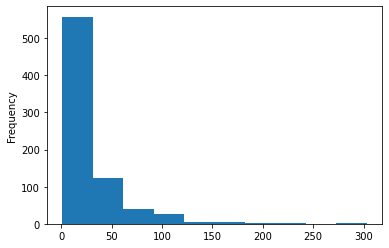

In [26]:
messages_with_scores.by_user_dialog_number.plot.hist()

<AxesSubplot:ylabel='Frequency'>

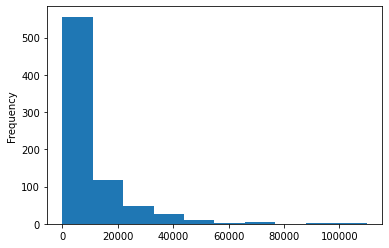

In [27]:
messages_with_scores.by_user_message_number.plot.hist()

In [28]:
messages_with_scores_many_data = messages_with_scores[messages_with_scores.by_user_message_number > 30]

In [29]:
messages_with_scores_many_data.shape

(718, 10)

In [33]:
messages_with_scores_many_data["text"] = messages_with_scores_many_data.user_texts.apply(lambda x: " ".join(map(str, x)))

In [34]:
messages_with_scores_many_data

,index,vk_id_encrypted,freud_install_time,who_score,diener_score,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised,text
0,2,435358060,2018-06-28 18:57:38,12.0,22.0,39,8623,[[за 1.12\nхол. в- 642\nэлектр.- 21344\nгаз - ...,[за 1.12\nхол. в- 642\nэлектр.- 21344\nгаз - 5...,435358060,за 1.12\nхол. в- 642\nэлектр.- 21344\nгаз - 53...
1,3,518613556,2018-07-17 11:38:02,23.0,24.0,17,4817,"[[это как?, Ясно, С праздником), :), как жизнь...","[это как?, Ясно, С праздником), :), как жизнь?...",518613556,это как? Ясно С праздником) :) как жизнь?) мои...
2,4,200269216,2018-08-28 13:33:33,10.0,9.0,15,1187,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216,"О, спасибо огромное) мне очень приятно что вы ..."
3,5,305836538,2018-07-21 22:51:49,10.0,15.0,9,21827,"[[Ну что ж.. Хатико ждал и мы подождем, Лунтик...","[Ну что ж.. Хатико ждал и мы подождем, Лунтик ...",305836538,Ну что ж.. Хатико ждал и мы подождем Лунтик ре...
5,7,313691105,2018-07-31 10:25:13,14.0,13.0,12,3323,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105,"Нашивки еще не делала, но пару раз вышивала на..."
...,...,...,...,...,...,...,...,...,...,...,...
759,851,540669219,2018-03-29 10:04:57,13.0,16.0,46,1033,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219,Немного 4 Я в курилке уже стою Что творишь? Ау...
760,852,354174379,2018-06-30 09:03:00,22.0,19.0,29,13012,"[[😂😂, оор, ты бы стал пересматривать наруто с ...","[😂😂, оор, ты бы стал пересматривать наруто с с...",354174379,😂😂 оор ты бы стал пересматривать наруто с само...
761,853,954555625,2018-08-27 01:15:08,16.0,15.0,31,3932,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625,"Настя, на всякий случай, если ещё не в курсе, ..."
762,854,849073825,2018-03-27 08:28:00,15.0,21.0,129,39918,"[[смотря что нужно, какие?, обратись лучше к н...","[смотря что нужно, какие?, обратись лучше к на...",849073825,смотря что нужно какие? обратись лучше к насте...


In [35]:
pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 2), 
               max_df = 0.98,
               min_df = 2,
               tokenizer = wordpunct_tokenize
            )
    ),
    #('pca', TruncatedSVD(500)), 
    ('lr', Ridge())
])

In [36]:
import numpy as np
from sklearn.model_selection import KFold

def base_estimations(target="who_score"):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        pipe.fit(messages_with_scores_many_data.text.iloc[train], messages_with_scores_many_data[target].iloc[train])
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    for name, values in scores.items():
        print()
        print("Result")
        print(f"{name}: {sum(values)/len(values)}")

Расчет базовой метерики на простом пайплайне из тф-идф и ридж регрессии. Используется кросс-валидация на 5 фолдов.

## Who score 


Report:
mean_squared_error: 20.7008
mean_absolute_error: 3.8297
r2_score 0.1393
pearsonr_corr: 0.3978, pearsonr_p: 0.0
spearman_corr: 0.4126, spearman_p: 0.0



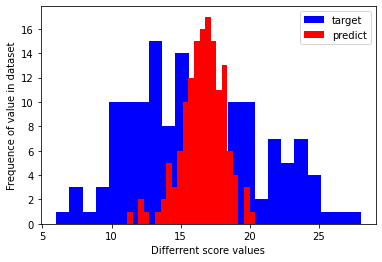

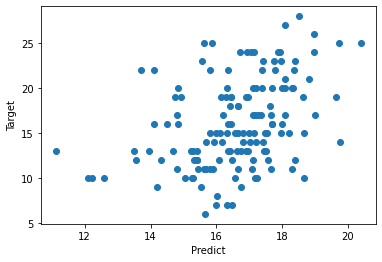

Report:
mean_squared_error: 15.3205
mean_absolute_error: 3.2108
r2_score 0.0675
pearsonr_corr: 0.272, pearsonr_p: 0.001
spearman_corr: 0.2634, spearman_p: 0.0014



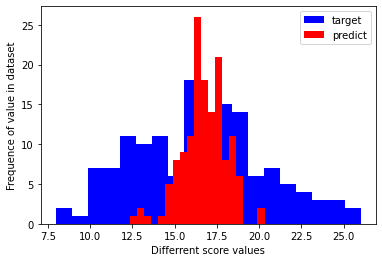

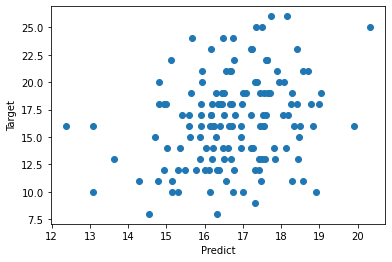

Report:
mean_squared_error: 24.8601
mean_absolute_error: 4.0528
r2_score 0.0747
pearsonr_corr: 0.277, pearsonr_p: 0.0008
spearman_corr: 0.2461, spearman_p: 0.0029



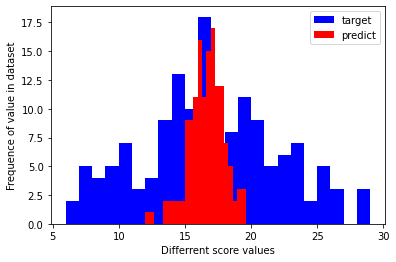

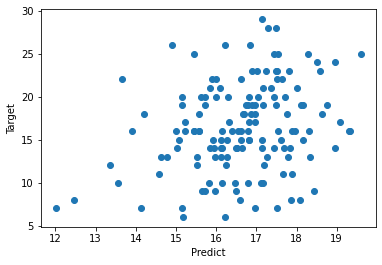

Report:
mean_squared_error: 25.9544
mean_absolute_error: 4.1657
r2_score -0.0034
pearsonr_corr: 0.2027, pearsonr_p: 0.0152
spearman_corr: 0.1925, spearman_p: 0.0212



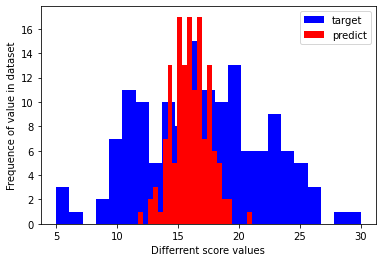

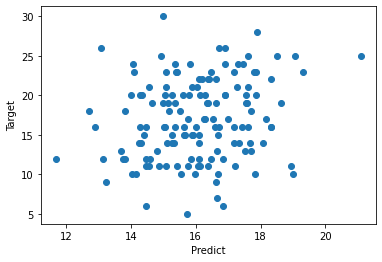

Report:
mean_squared_error: 20.7174
mean_absolute_error: 3.7086
r2_score 0.0196
pearsonr_corr: 0.1817, pearsonr_p: 0.0298
spearman_corr: 0.1162, spearman_p: 0.1671



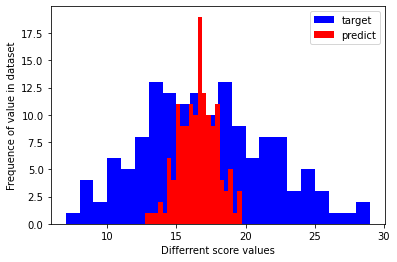

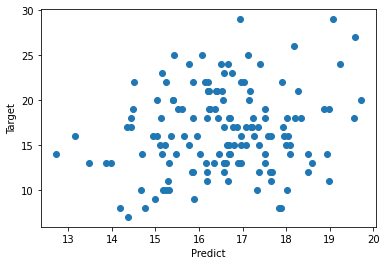


Result
mae: 21.510640000000002

Result
mse: 3.79352

Result
r: 0.05954

Result
pearson: 0.2662527281893539


In [37]:
base_estimations()

## Diener score

Report:
mean_squared_error: 46.1787
mean_absolute_error: 5.6993
r2_score 0.0326
pearsonr_corr: 0.1968, pearsonr_p: 0.0181
spearman_corr: 0.2046, spearman_p: 0.0139



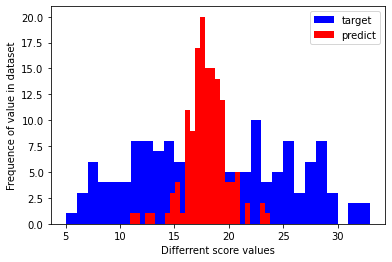

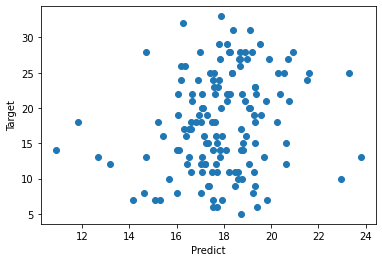

Report:
mean_squared_error: 41.2457
mean_absolute_error: 5.3905
r2_score -0.0197
pearsonr_corr: 0.1567, pearsonr_p: 0.0607
spearman_corr: 0.1336, spearman_p: 0.1105



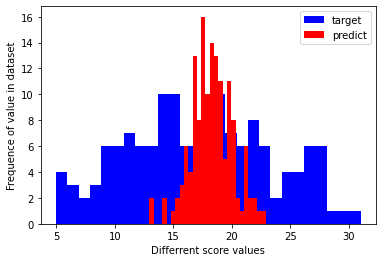

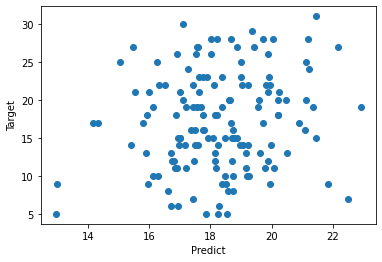

Report:
mean_squared_error: 43.6333
mean_absolute_error: 5.442
r2_score 0.0577
pearsonr_corr: 0.2691, pearsonr_p: 0.0011
spearman_corr: 0.2823, spearman_p: 0.0006



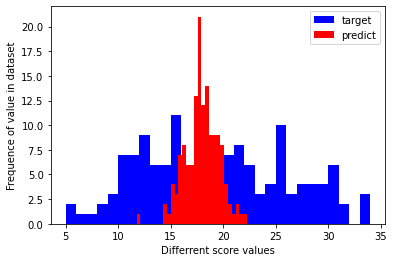

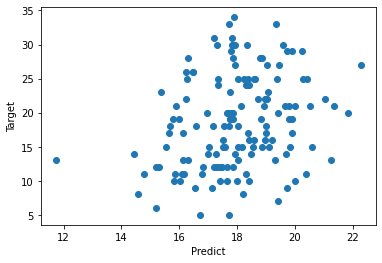

Report:
mean_squared_error: 46.0115
mean_absolute_error: 5.7445
r2_score 0.0342
pearsonr_corr: 0.2083, pearsonr_p: 0.0125
spearman_corr: 0.2134, spearman_p: 0.0105



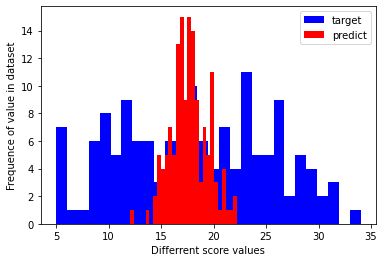

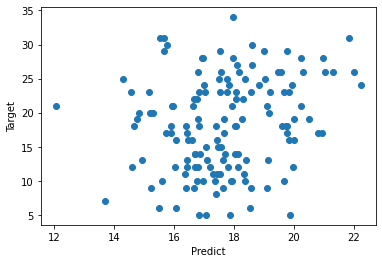

Report:
mean_squared_error: 40.725
mean_absolute_error: 5.253
r2_score -0.0393
pearsonr_corr: 0.105, pearsonr_p: 0.2121
spearman_corr: 0.1116, spearman_p: 0.1845



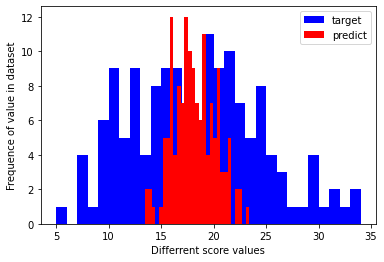

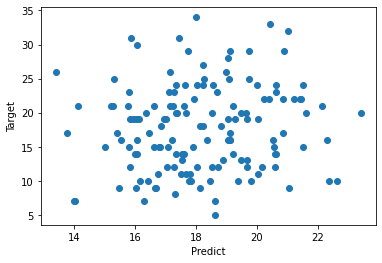


Result
mae: 43.55883999999999

Result
mse: 5.50586

Result
r: 0.0131

Result
pearson: 0.18717382301104385


In [38]:
base_estimations(target="diener_score")

In [41]:
def with_augs_estimations(target = "who_score", augs_coef = 2):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        augmented_data = {"source": [], "target": []}
        for score, texts in zip(messages_with_scores_many_data[target].iloc[train].tolist(), messages_with_scores_many_data.by_user_by_speakers_messages.iloc[train].tolist()):
            current_pos = 0
            bound = int(len(texts) / augs_coef)
            for part in range(augs_coef):
                text = " ".join([str(m) for mes in texts[current_pos: current_pos + bound] for m in mes])
                augmented_data["source"].append(text)
                augmented_data["target"].append(score)
                current_pos += bound
        
        augmented_data = pd.DataFrame(augmented_data)        
        pipe.fit(augmented_data.source, augmented_data.target)
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    print()
    print("Result")
    for name, values in scores.items():
        print(f"{name}: {sum(values)/len(values)}")

Расчет метерики на простом пайплайне из тф-идф и ридж регрессии с аугментацией. 
Суть аугментации: сообщения каждого пользователя делятся на n равных частьей без привязки к диалогам (по дефолту 2 части). 
Так как каждая часть относится к одному и тому же пользователю, то она становится независимым тренировочным примеров с таргетом равным таргету пользователя. Таким образом выборка увеличивается в n-раз. 
Используется кросс-валидация на 5 фолдов.

## Who score

Report:
mean_squared_error: 20.5798
mean_absolute_error: 3.8118
r2_score 0.1444
pearsonr_corr: 0.3956, pearsonr_p: 0.0
spearman_corr: 0.4293, spearman_p: 0.0



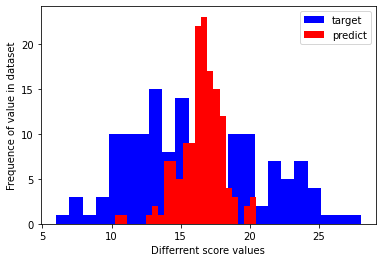

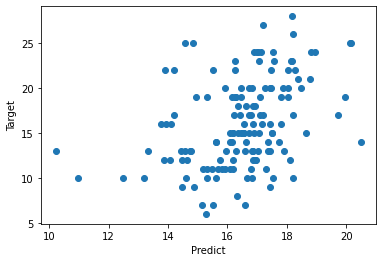

Report:
mean_squared_error: 15.7205
mean_absolute_error: 3.2551
r2_score 0.0432
pearsonr_corr: 0.2267, pearsonr_p: 0.0063
spearman_corr: 0.2096, spearman_p: 0.0117



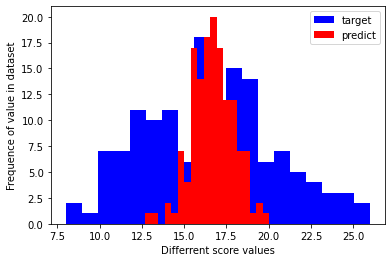

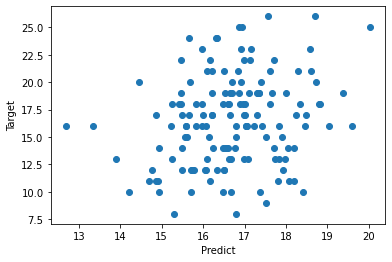

Report:
mean_squared_error: 24.6488
mean_absolute_error: 4.053
r2_score 0.0826
pearsonr_corr: 0.2913, pearsonr_p: 0.0004
spearman_corr: 0.263, spearman_p: 0.0015



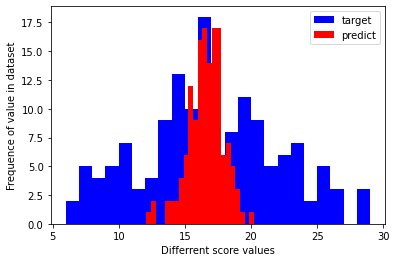

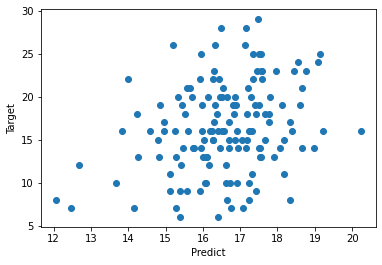

Report:
mean_squared_error: 25.9667
mean_absolute_error: 4.1878
r2_score -0.0039
pearsonr_corr: 0.2035, pearsonr_p: 0.0148
spearman_corr: 0.2023, spearman_p: 0.0154



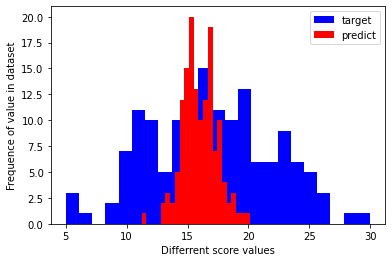

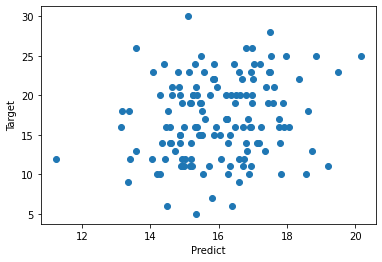

Report:
mean_squared_error: 20.6355
mean_absolute_error: 3.6816
r2_score 0.0235
pearsonr_corr: 0.1816, pearsonr_p: 0.03
spearman_corr: 0.1202, spearman_p: 0.1529



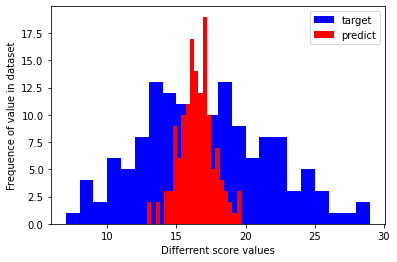

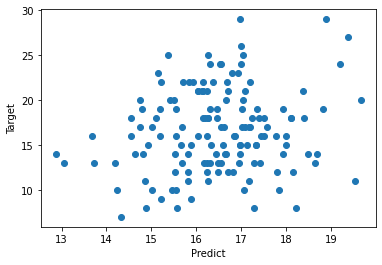


Result
mae: 21.51026
mse: 3.79786
r: 0.05796
pearson: 0.25973948537688446


In [42]:
with_augs_estimations()

Report:
mean_squared_error: 20.6484
mean_absolute_error: 3.8037
r2_score 0.1415
pearsonr_corr: 0.3907, pearsonr_p: 0.0
spearman_corr: 0.4256, spearman_p: 0.0



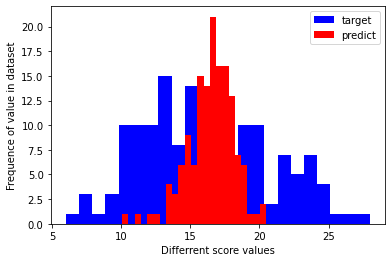

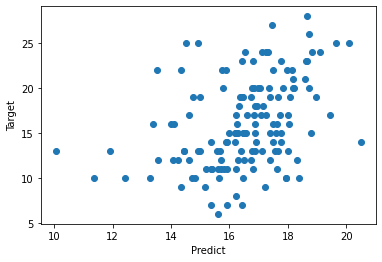

Report:
mean_squared_error: 15.8908
mean_absolute_error: 3.2669
r2_score 0.0328
pearsonr_corr: 0.2147, pearsonr_p: 0.0098
spearman_corr: 0.1995, spearman_p: 0.0165



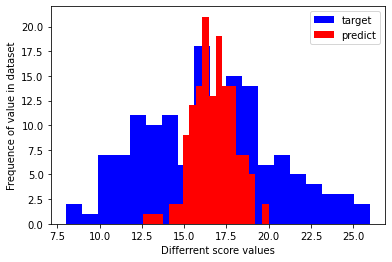

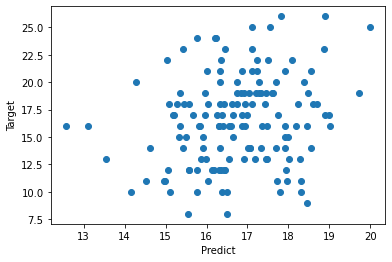

Report:
mean_squared_error: 24.8521
mean_absolute_error: 4.0603
r2_score 0.075
pearsonr_corr: 0.277, pearsonr_p: 0.0008
spearman_corr: 0.2604, spearman_p: 0.0016



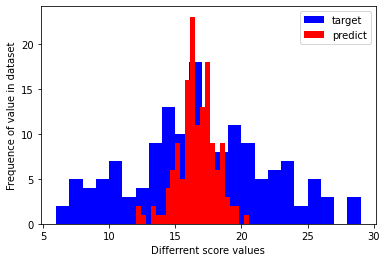

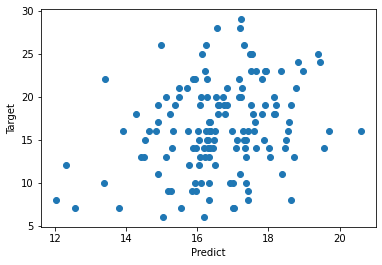

Report:
mean_squared_error: 25.928
mean_absolute_error: 4.1735
r2_score -0.0024
pearsonr_corr: 0.2098, pearsonr_p: 0.0119
spearman_corr: 0.2111, spearman_p: 0.0114



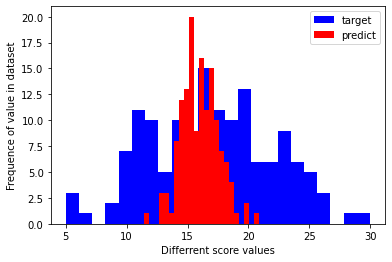

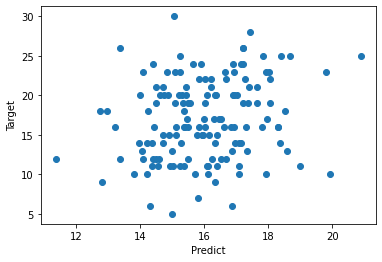

Report:
mean_squared_error: 20.8555
mean_absolute_error: 3.7268
r2_score 0.0131
pearsonr_corr: 0.1733, pearsonr_p: 0.0385
spearman_corr: 0.1033, spearman_p: 0.2195



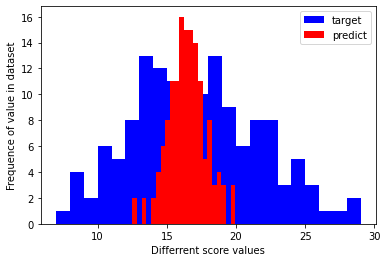

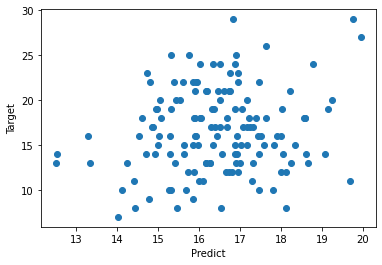


Result
mae: 21.63496
mse: 3.8062400000000003
r: 0.05199999999999999
pearson: 0.2530859524365921


In [43]:
with_augs_estimations(augs_coef = 3)

Report:
mean_squared_error: 20.611
mean_absolute_error: 3.7916
r2_score 0.1431
pearsonr_corr: 0.386, pearsonr_p: 0.0
spearman_corr: 0.4133, spearman_p: 0.0



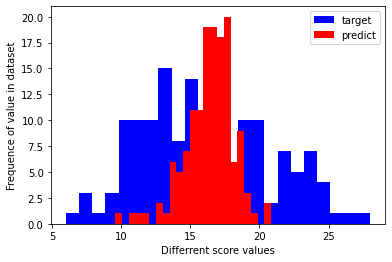

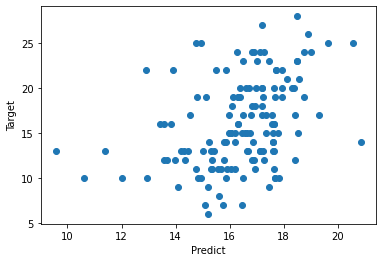

Report:
mean_squared_error: 15.9685
mean_absolute_error: 3.2859
r2_score 0.0281
pearsonr_corr: 0.2126, pearsonr_p: 0.0105
spearman_corr: 0.1828, spearman_p: 0.0283



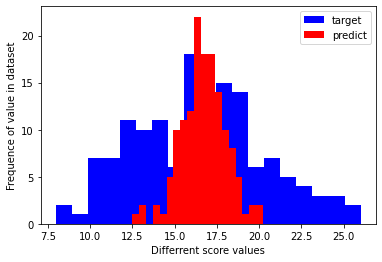

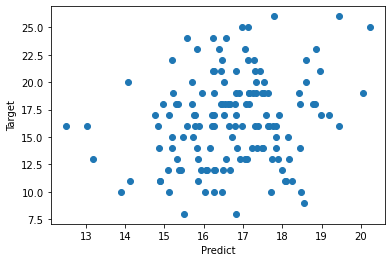

Report:
mean_squared_error: 24.806
mean_absolute_error: 4.0349
r2_score 0.0767
pearsonr_corr: 0.2789, pearsonr_p: 0.0007
spearman_corr: 0.2518, spearman_p: 0.0023



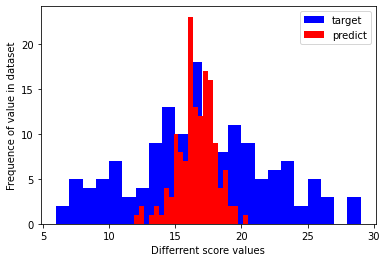

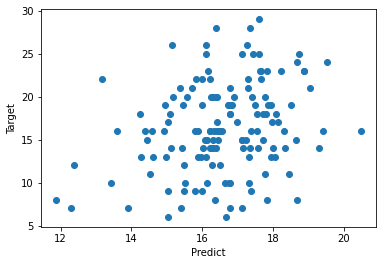

Report:
mean_squared_error: 26.1937
mean_absolute_error: 4.1988
r2_score -0.0126
pearsonr_corr: 0.2061, pearsonr_p: 0.0135
spearman_corr: 0.2088, spearman_p: 0.0123



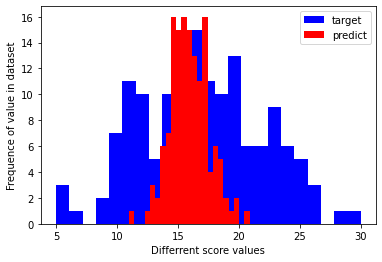

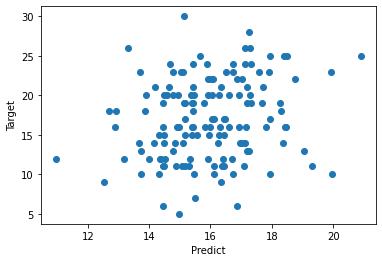

Report:
mean_squared_error: 21.0518
mean_absolute_error: 3.7294
r2_score 0.0038
pearsonr_corr: 0.1633, pearsonr_p: 0.0513
spearman_corr: 0.1071, spearman_p: 0.2028



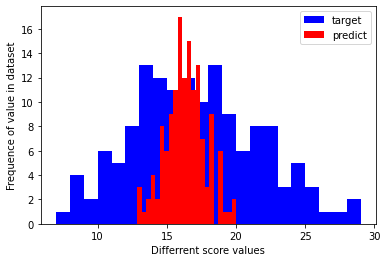

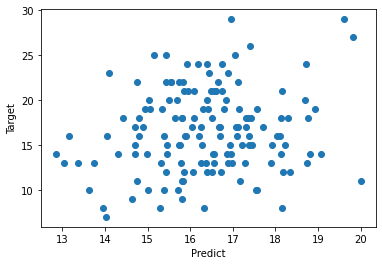


Result
mae: 21.726200000000002
mse: 3.80812
r: 0.04782
pearson: 0.24939131821109148


In [44]:
with_augs_estimations(augs_coef = 4)

## Diener score

Report:
mean_squared_error: 46.3129
mean_absolute_error: 5.7264
r2_score 0.0298
pearsonr_corr: 0.1916, pearsonr_p: 0.0214
spearman_corr: 0.2277, spearman_p: 0.006



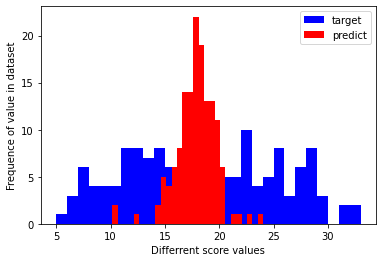

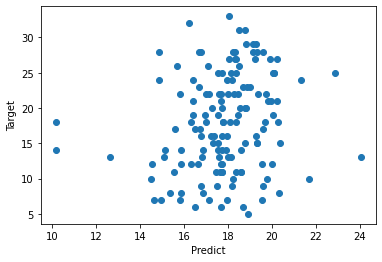

Report:
mean_squared_error: 41.8703
mean_absolute_error: 5.4187
r2_score -0.0351
pearsonr_corr: 0.1352, pearsonr_p: 0.1063
spearman_corr: 0.1066, spearman_p: 0.2033



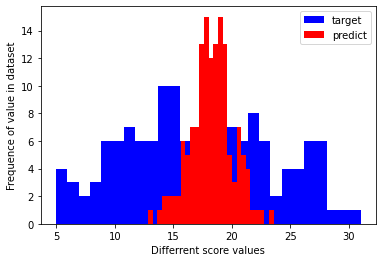

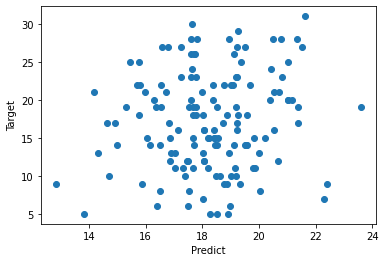

Report:
mean_squared_error: 44.0329
mean_absolute_error: 5.5142
r2_score 0.0491
pearsonr_corr: 0.2549, pearsonr_p: 0.0021
spearman_corr: 0.2507, spearman_p: 0.0024



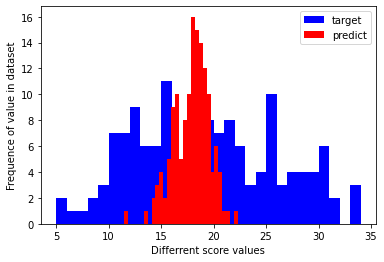

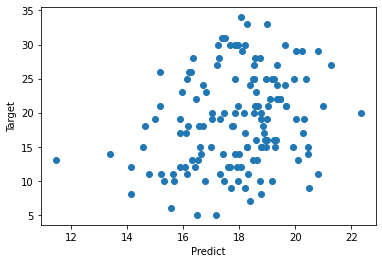

Report:
mean_squared_error: 45.2356
mean_absolute_error: 5.7059
r2_score 0.0505
pearsonr_corr: 0.2421, pearsonr_p: 0.0036
spearman_corr: 0.2425, spearman_p: 0.0035



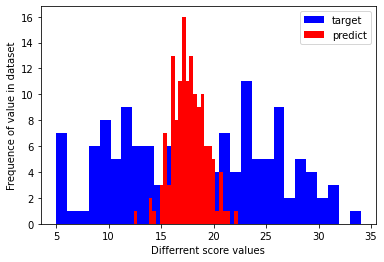

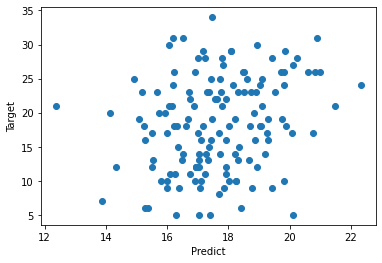

Report:
mean_squared_error: 41.1529
mean_absolute_error: 5.321
r2_score -0.0503
pearsonr_corr: 0.0739, pearsonr_p: 0.3805
spearman_corr: 0.0762, spearman_p: 0.3655



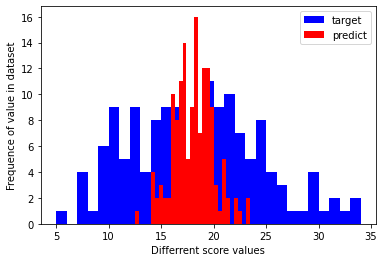

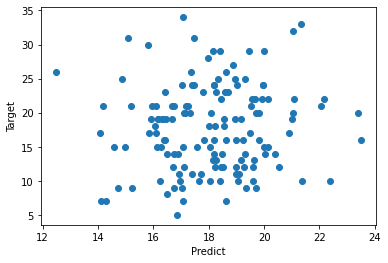


Result
mae: 43.72092
mse: 5.53724
r: 0.008799999999999999
pearson: 0.17952775118129877


In [45]:
with_augs_estimations(target="diener_score")

Report:
mean_squared_error: 46.1697
mean_absolute_error: 5.7136
r2_score 0.0328
pearsonr_corr: 0.1956, pearsonr_p: 0.0188
spearman_corr: 0.2235, spearman_p: 0.0071



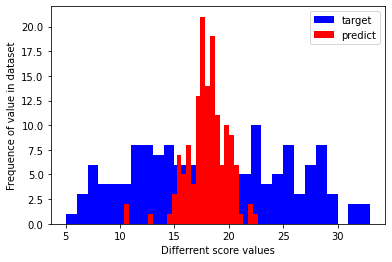

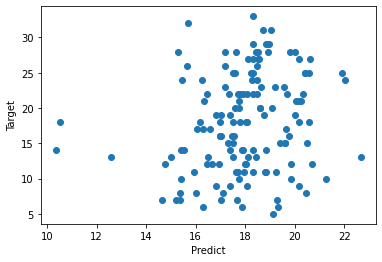

Report:
mean_squared_error: 41.7569
mean_absolute_error: 5.4009
r2_score -0.0323
pearsonr_corr: 0.1521, pearsonr_p: 0.0688
spearman_corr: 0.1277, spearman_p: 0.1273



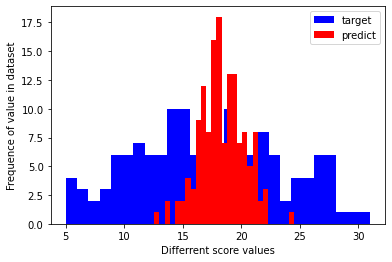

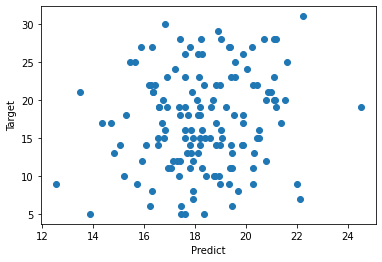

Report:
mean_squared_error: 44.1215
mean_absolute_error: 5.465
r2_score 0.0472
pearsonr_corr: 0.2506, pearsonr_p: 0.0024
spearman_corr: 0.253, spearman_p: 0.0022



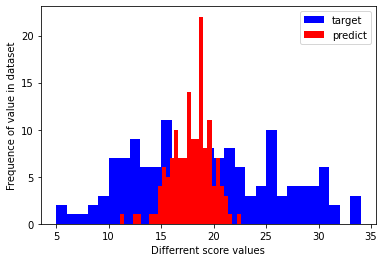

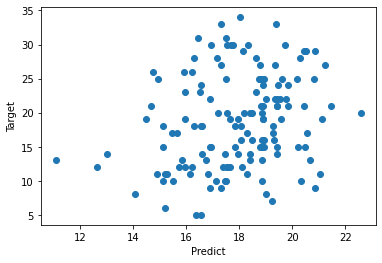

Report:
mean_squared_error: 45.5609
mean_absolute_error: 5.7332
r2_score 0.0437
pearsonr_corr: 0.2279, pearsonr_p: 0.0062
spearman_corr: 0.2407, spearman_p: 0.0038



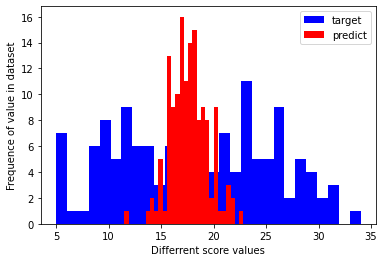

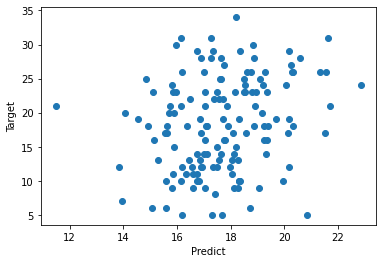

Report:
mean_squared_error: 41.5902
mean_absolute_error: 5.3346
r2_score -0.0614
pearsonr_corr: 0.0722, pearsonr_p: 0.3912
spearman_corr: 0.0805, spearman_p: 0.3391



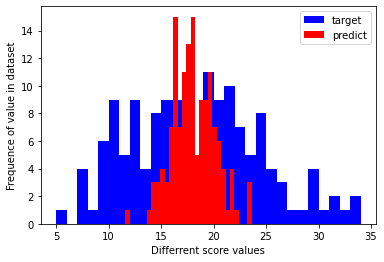

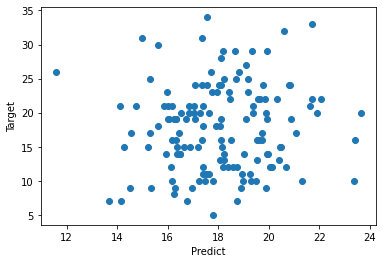


Result
mae: 43.83984
mse: 5.52946
r: 0.006000000000000001
pearson: 0.17969265065405565


In [46]:
with_augs_estimations(target="diener_score", augs_coef = 3)

Report:
mean_squared_error: 46.3884
mean_absolute_error: 5.7559
r2_score 0.0282
pearsonr_corr: 0.1929, pearsonr_p: 0.0205
spearman_corr: 0.2183, spearman_p: 0.0086



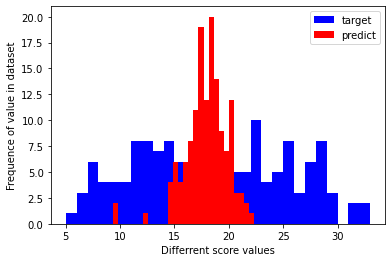

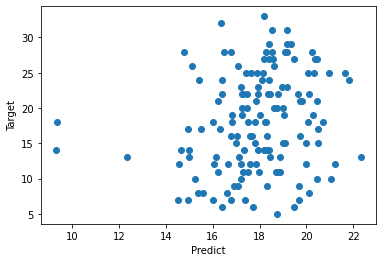

Report:
mean_squared_error: 42.2547
mean_absolute_error: 5.4319
r2_score -0.0446
pearsonr_corr: 0.1405, pearsonr_p: 0.093
spearman_corr: 0.1096, spearman_p: 0.191



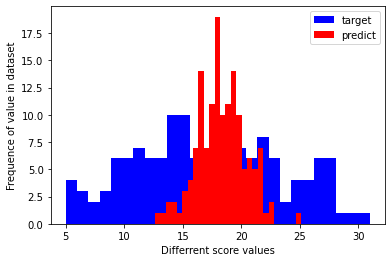

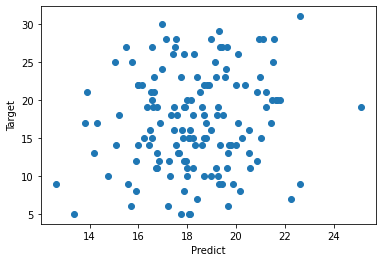

Report:
mean_squared_error: 44.3295
mean_absolute_error: 5.4984
r2_score 0.0427
pearsonr_corr: 0.246, pearsonr_p: 0.003
spearman_corr: 0.2584, spearman_p: 0.0018



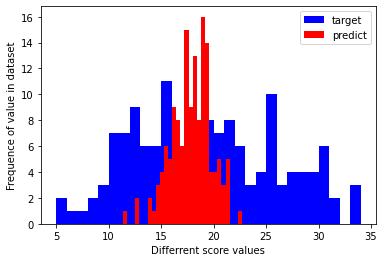

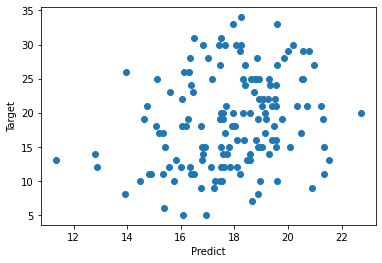

Report:
mean_squared_error: 45.3894
mean_absolute_error: 5.7034
r2_score 0.0473
pearsonr_corr: 0.2384, pearsonr_p: 0.0041
spearman_corr: 0.2299, spearman_p: 0.0057



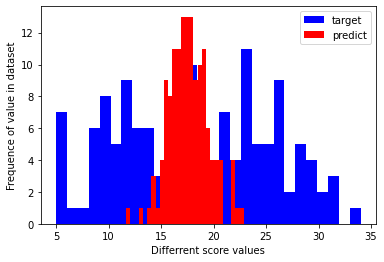

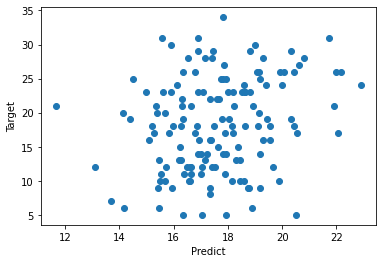

Report:
mean_squared_error: 41.2613
mean_absolute_error: 5.3443
r2_score -0.053
pearsonr_corr: 0.0913, pearsonr_p: 0.2782
spearman_corr: 0.09, spearman_p: 0.2853



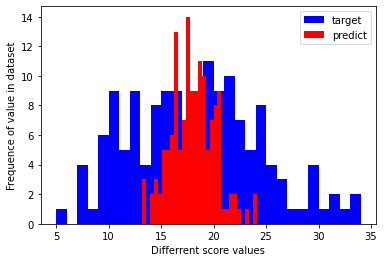

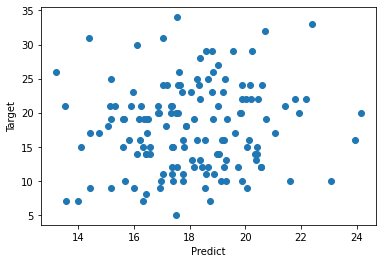


Result
mae: 43.92466
mse: 5.54678
r: 0.00412
pearson: 0.18181562509305033


In [47]:
with_augs_estimations(target="diener_score", augs_coef = 4)